# Download data

In [1]:
# Fruits-360 dataset をダウンロードし、解凍する

!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/ 

--2021-02-11 05:58:57--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.56.88
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.56.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418811602 (399M) [application/octet-stream]
Saving to: ‘./data/rp73yg93n8-1.zip’

rp73yg93n8-1.zip    100%[===================>] 399.41M  21.5MB/s    in 20s     

2021-02-11 05:59:18 (20.1 MB/s) - ‘./data/rp73yg93n8-1.zip’ saved [418811602/418811602]

Archive:  ./data/rp73yg93n8-1.zip
  inflating: ./data/fruits-360_dataset.zip  


# Import

In [2]:
import os
import random
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
from skimage import io, transform
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

# Config

In [3]:
IMAGE_SIZE = 96  # 画像の読み込みサイズ
EMBED_SIZE = 128  # 潜在変数zの次元数
BATCH_SIZE = 16  # バッチサイズ
EPOCHS = 1000  # エポック数
LR = 0.0004  # 学習率

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが使えるならGPUで、そうでないならCPUで計算する
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  

In [5]:
COLAB_FLG = False

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/MyDrive/Colab Notebooks/gan_sample/chapter8"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    

SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/EfficientGAN_L1/image/image_from_z/"  # 乱数から生成した画像の保存先
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/EfficientGAN_L1/image/RECONSTRUCT/"  # 再構成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

# Data Loader

In [6]:
train_root = './data/fruits-360/Training/Physalis/'  # train dataの保存してあるディレクトリ
val_root = './data/fruits-360/Test/Physalis/'  # val dataの保存してあるディレクトリ

In [7]:
# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [8]:
# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
}

In [9]:
# 読み込む

train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

val_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Model

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2), #48x48
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2), #24x24

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2), #12x12
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2), #6x6

        
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1

            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2), #1x1
        )
        
        self.last = nn.Sequential(
            nn.Conv2d(512, EMBED_SIZE, kernel_size=1, stride=1, bias=False)
        )


    def forward(self, x):
        
        out = self.main(x)

        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [11]:
# ネットワークを可視化する

summary(Encoder().to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,536
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         LeakyReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]         131,072
       BatchNorm2d-8          [-1, 128, 12, 12]             256
         LeakyReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         524,288
      BatchNorm2d-11            [-1, 256, 6, 6]             512
        LeakyReLU-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 1, 1]       4,718,592
      BatchNorm2d-14            [-1, 51

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [13]:
# ネットワークを可視化する

summary(Generator().to(device), tuple([EMBED_SIZE, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
         LeakyReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
         LeakyReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         LeakyReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
        LeakyReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),

            nn.AvgPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),
            
            nn.AvgPool2d(2),
            nn.Conv2d(256, 256, kernel_size=6, stride=1) #1x1

        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(EMBED_SIZE, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
            

            
        )
        
        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
            
            
 
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):
        
        output_x = self.x_layer(x)
        output_z = self.z_layer(z)
        
        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)
        
        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [15]:
# ネットワークを可視化する

summary(Discriminator().to(device), [(3, IMAGE_SIZE, IMAGE_SIZE), (EMBED_SIZE, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
         LeakyReLU-2           [-1, 32, 96, 96]               0
         Dropout2d-3           [-1, 32, 96, 96]               0
         AvgPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 48, 48]          18,496
       BatchNorm2d-6           [-1, 64, 48, 48]             128
         LeakyReLU-7           [-1, 64, 48, 48]               0
         Dropout2d-8           [-1, 64, 48, 48]               0
         AvgPool2d-9           [-1, 64, 24, 24]               0
           Conv2d-10          [-1, 128, 24, 24]          73,856
      BatchNorm2d-11          [-1, 128, 24, 24]             256
        LeakyReLU-12          [-1, 128, 24, 24]               0
        Dropout2d-13          [-1, 128, 24, 24]               0
        AvgPool2d-14          [-1, 128,

In [16]:
# 重みの初期化を行う関数


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find("Linear") != -1:
        m.bias.data.fill_(0)

In [17]:
model_E = Encoder().to(device)
model_E.apply(weights_init)

model_G = Generator().to(device)
model_G.apply(weights_init)

model_D = Discriminator().to(device)
model_D.apply(weights_init)

criterion = nn.BCELoss()
criterion_L1 = nn.L1Loss(reduction="sum")  # L1 lossも学習時に用いる

optimizer_ge = torch.optim.Adam(list(model_G.parameters()) + list(model_E.parameters()), lr= LR, betas=(0.5,0.999))
optimizer_d = torch.optim.Adam(model_D.parameters(), lr= LR,betas=(0.5,0.999))
scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

# Train

In [18]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = model_D(x, E_x)
    _,G_E_x_feature = model_D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss


In [19]:
loss_d_list, loss_ge_list, anomaly_score_list = [], [], []


for epoch in range(EPOCHS):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        model_G.train()
        model_D.train()
        model_E.train()
        # set values
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).to(device)
        
        # noise for discriminator
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (EPOCHS - epoch) / EPOCHS),
                          requires_grad=False).to(device)

        # discriminator
        optimizer_d.zero_grad()
        
        E_x = model_E(x) 
        p_true, _ = model_D(x + noise1, E_x)
        
        G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # generator and encoder
        optimizer_ge.zero_grad()
        
        G_E_x = model_G(E_x)
        E_G_z = model_E(G_z)
    
        p_true, _ = model_D(x + noise1, E_x)
        
        # G_z = model_G(z)
        p_fake, _ = model_D(G_z + noise2, z)
        
        
        loss_ge_1 = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge_2 = criterion_L1(x, G_E_x) +  criterion_L1(z, E_G_z)
        
        alpha = 0.01
        
        loss_ge = (1 - alpha)*loss_ge_1 + alpha*loss_ge_2
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # record anomaly score
        
        model_G.eval()
        model_D.eval()
        model_E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = model_E(x_val)
        G_E_x_val = model_G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)

            
        # save images
        if i == 0:
            
            model_G.eval()
            model_D.eval()
            model_E.eval()
        
            save_image_size_for_z = min(BATCH_SIZE, 8)
            save_images = model_G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(BATCH_SIZE, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = model_G(model_E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # record loss
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{EPOCHS} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    loss_d_list.append(loss_d_mean)
    loss_ge_list.append(loss_ge_mean)
    anomaly_score_list.append(anomaly_score_mean)
    
    # save model
    if (epoch + 1) % 10 == 0:
        torch.save(model_G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch + 1}.pkl')
        torch.save(model_E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch + 1}.pkl')
        torch.save(model_D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch + 1}.pkl')


0/1000 epoch ge_loss: 895.430 d_loss: 0.311 anomaly_score: 84305.380
1/1000 epoch ge_loss: 609.117 d_loss: 0.024 anomaly_score: 57383.985
2/1000 epoch ge_loss: 406.502 d_loss: 0.099 anomaly_score: 32020.681
3/1000 epoch ge_loss: 286.008 d_loss: 0.074 anomaly_score: 20771.443
4/1000 epoch ge_loss: 216.775 d_loss: 0.025 anomaly_score: 15905.602
5/1000 epoch ge_loss: 171.096 d_loss: 0.048 anomaly_score: 13156.652
6/1000 epoch ge_loss: 138.321 d_loss: 0.015 anomaly_score: 10148.496
7/1000 epoch ge_loss: 114.570 d_loss: 0.020 anomaly_score: 8402.434
8/1000 epoch ge_loss: 99.266 d_loss: 0.013 anomaly_score: 8001.118
9/1000 epoch ge_loss: 86.847 d_loss: 0.013 anomaly_score: 6798.740
10/1000 epoch ge_loss: 81.390 d_loss: 0.020 anomaly_score: 6445.538
11/1000 epoch ge_loss: 73.979 d_loss: 0.014 anomaly_score: 5970.614
12/1000 epoch ge_loss: 69.283 d_loss: 0.020 anomaly_score: 5321.928
13/1000 epoch ge_loss: 67.035 d_loss: 0.047 anomaly_score: 4929.395
14/1000 epoch ge_loss: 62.690 d_loss: 0.010

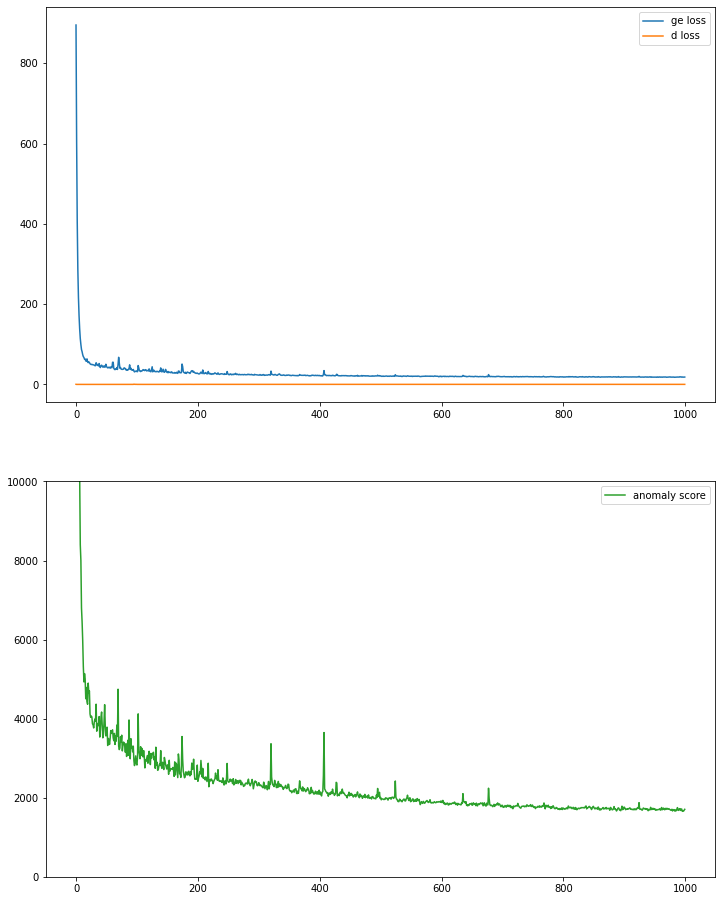

In [23]:
plt.figure(figsize=(12, 8*2))

plt.subplot(211)
plt.plot(range(len(loss_ge_list)), loss_ge_list, label="ge loss",color="C0")
plt.legend()

plt.plot(range(len(loss_d_list)), loss_d_list, label="d loss",color="C1")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_score_list)), anomaly_score_list, label="anomaly score",color="C2")
plt.legend()
plt.ylim(0, 10000)

plt.show()

# Test Anomaly detection

In [24]:
LOAD_EPOCH = 1000


model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
model_G.eval()


model_E = Encoder().to(device)
model_E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
model_E.eval()

model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
model_D.eval()

print("load model")

load model


Anomaly_score: 260.773


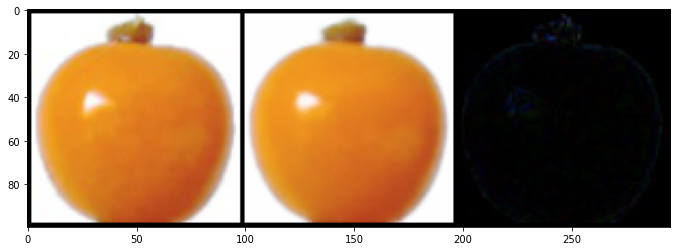

Anomaly_score: 225.354


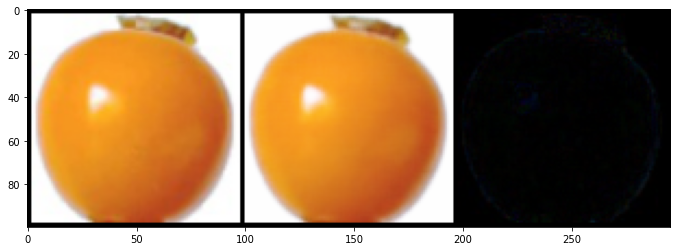

Anomaly_score: 241.662


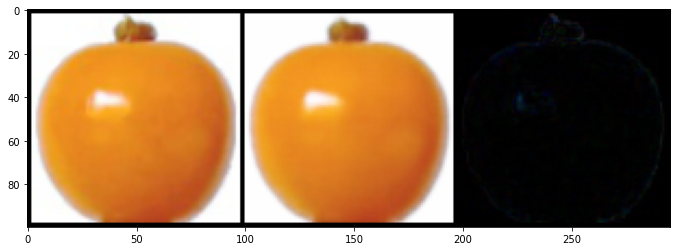

Anomaly_score: 377.269


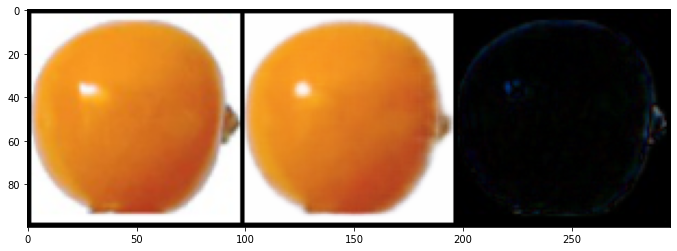

Anomaly_score: 560.683


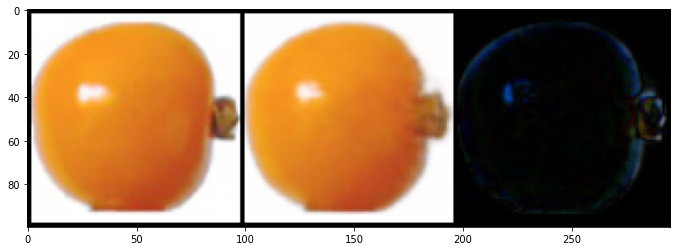

Anomaly_score: 282.880


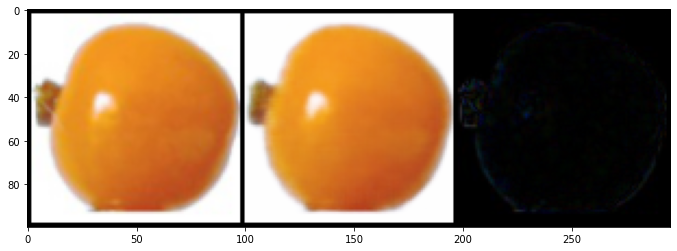

Anomaly_score: 255.860


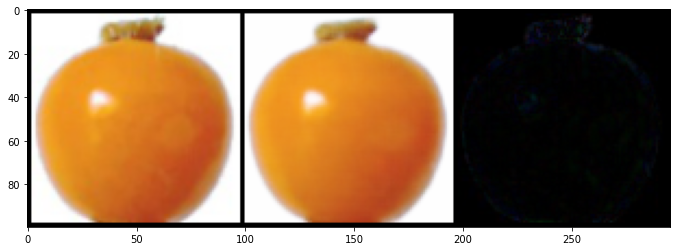

Anomaly_score: 258.285


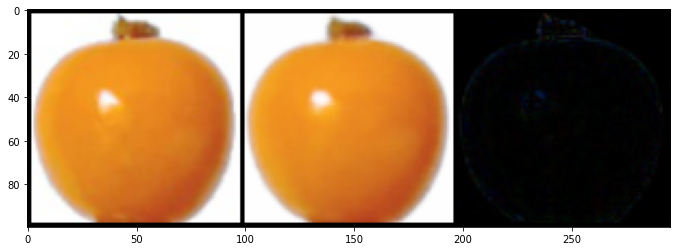

Anomaly_score: 270.702


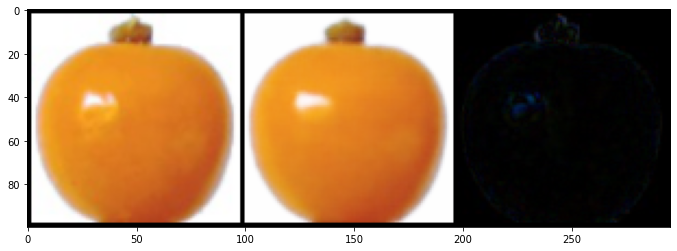

Anomaly_score: 278.268


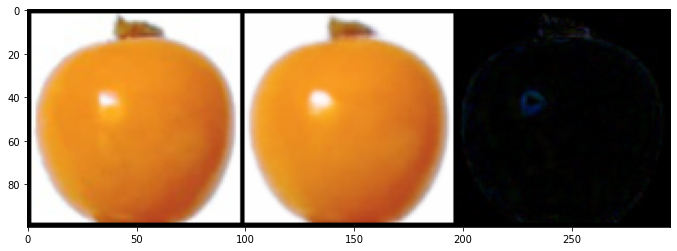

In [27]:
random_image_size = 10

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()

In [33]:
# 画像に傷を模した記号を付与する関数

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
images_path = glob('./data/fruits-360/Test/Physalis/*.jpg')
[add_damage(image_path) for image_path in images_path]
print("add damage")

add damage


Anomaly_score: 873.671


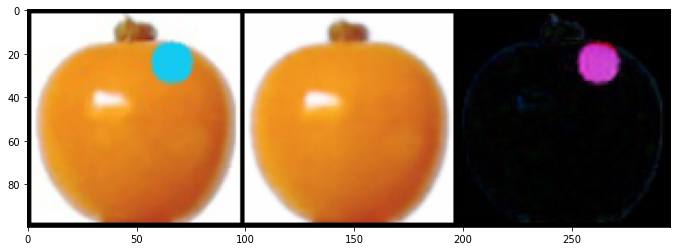

Anomaly_score: 1028.939


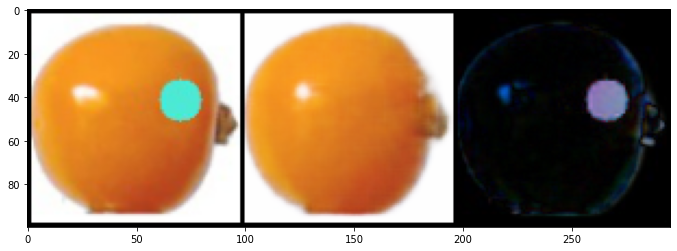

Anomaly_score: 591.194


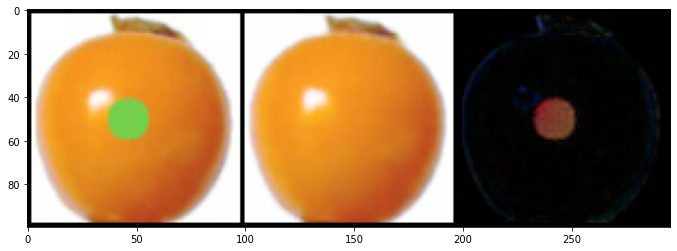

Anomaly_score: 824.452


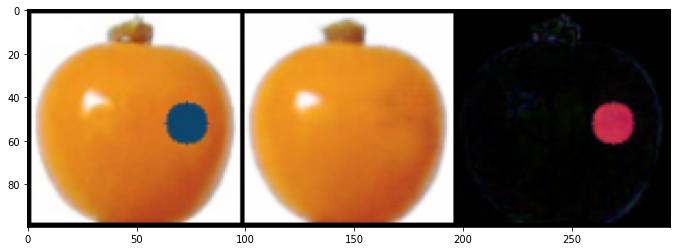

Anomaly_score: 350.234


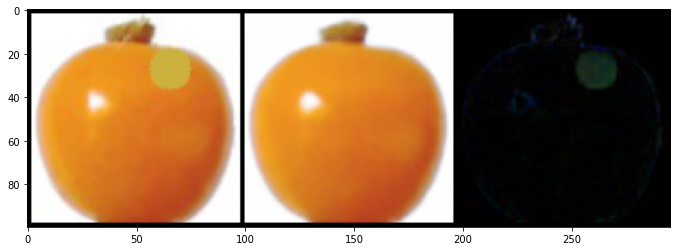

Anomaly_score: 802.632


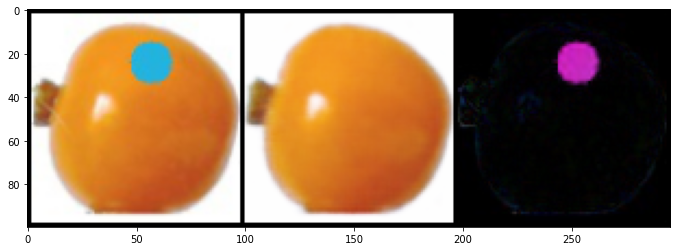

Anomaly_score: 514.662


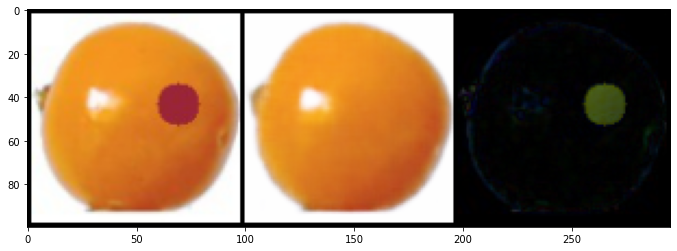

Anomaly_score: 643.025


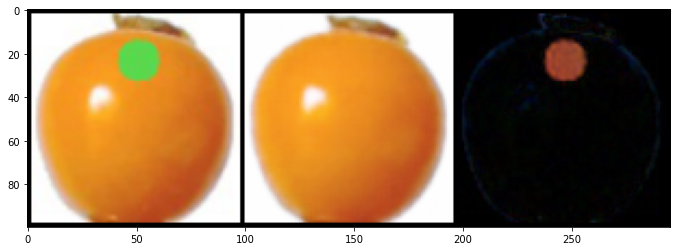

Anomaly_score: 654.364


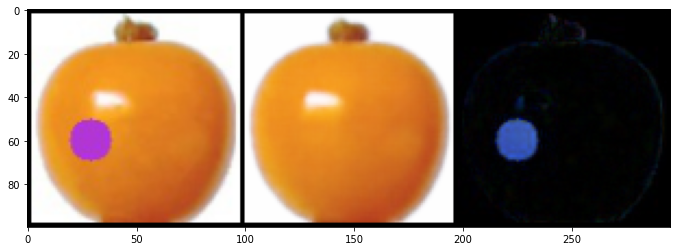

Anomaly_score: 584.300


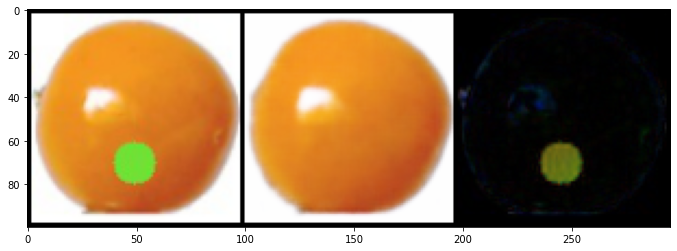

In [34]:
# 異常な画像で実行

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

# うまく再現されず、異常スコアが高くなっていれば成功
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, 96, 96).to(device)
    E_x = model_E(x)
    G_E_x = model_G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow(joined_image)
    plt.show()
